In [1]:
pip install gdown

In [2]:
!gdown 1-S5YkYSscrzSd_QArhC6R7qIMW2abc9s

Downloading...
From: https://drive.google.com/uc?id=1-S5YkYSscrzSd_QArhC6R7qIMW2abc9s
To: /content/Copy of FruitinAmazon.zip
100% 1.24M/1.24M [00:00<00:00, 12.5MB/s]


In [3]:
!unzip '/content/Copy of FruitinAmazon.zip'

Archive:  /content/Copy of FruitinAmazon.zip
  inflating: FruitinAmazon/test/cupuacu/download (5).jpeg  
  inflating: FruitinAmazon/test/acai/images (2).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (3).jpeg  
  inflating: FruitinAmazon/test/acai/images (16).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (2).jpeg  
  inflating: FruitinAmazon/train/pupunha/images (1).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (2).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (1).jpeg  
  inflating: FruitinAmazon/train/acai/images (3).jpeg  
  inflating: FruitinAmazon/train/acai/images (4).jpeg  
  inflating: FruitinAmazon/test/graviola/download (1).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (11).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (4).jpeg  
  inflating: FruitinAmazon/train/acai/images (11).jpeg  
  inflating: FruitinAmazon/test/tucuma/download (1).jpeg  
  inflating: FruitinAmazon/test/acai/images.jpeg  
  inflating: FruitinAmaz

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [5]:
# Define dataset paths
train_dir = "/content/FruitinAmazon/train"
test_dir = "/content/FruitinAmazon/test"

In [6]:
# Define image size
img_height, img_width = 28, 28

In [7]:
import os
train_dir = "/content/FruitinAmazon/train"
# Get class names (subdirectories)
class_names = sorted(os.listdir("/content/FruitinAmazon/train"))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


In [8]:
from PIL import Image, UnidentifiedImageError
corrupted_images = [] # List to store corrupted images path
# Loop through each class folder and check for corrupted images
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path): # Ensure it’s a valid directory
    images = os.listdir(class_path)
    for img_name in images:
      img_path = os.path.join(class_path, img_name)
      try:
        with Image.open(img_path) as img:
          img.verify() # Verify image integrity
      except (IOError, UnidentifiedImageError):
        corrupted_images.append(img_path)

# Print results
if corrupted_images:
  print("\nCorrupted Images Found:")
  for img in corrupted_images:
    print(img)
else:
  print("\nNo corrupted images found.")


No corrupted images found.


In [9]:
# Dictionary to store class counts
class_counts = {}
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[class_name] = len(images) # Count images in each class
# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>10}")
print("=" * 45)
for class_name, count in class_counts.items():
  print(f"{class_name:<25}{count:>15}") # Indent this line to be part of the for loop
print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


In [10]:
import random
selected_images = [] # Store image paths
selected_labels = [] # Store corresponding class names
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    # Search for images with supported extensions (case-insensitive)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if images: # Ensure the class folder is not empty
      selected_img = os.path.join(class_path, random.choice(images))
      selected_images.append(selected_img)
      selected_labels.append(class_name)
# Check if any images were selected
if not selected_images:
    print("Warning: No images found in the specified directory.")

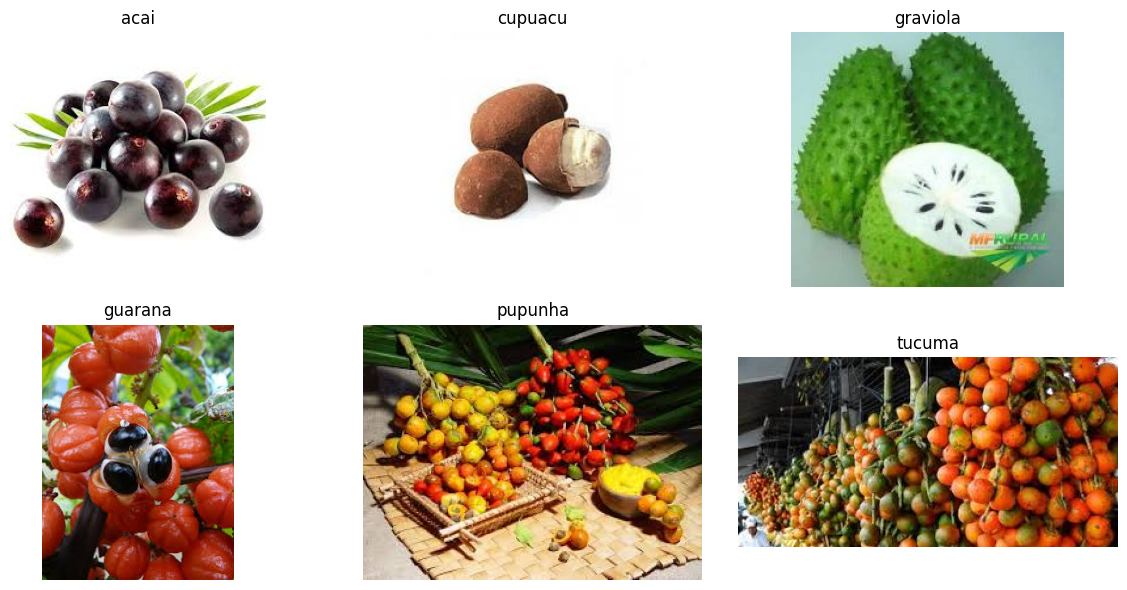

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Determine grid size
num_classes = len(selected_images)
cols = (num_classes + 1) // 2 # Determine columns
rows = 2 # Fixed rows for layout
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
  if i < num_classes:
    img = mpimg.imread(selected_images[i])
    ax.imshow(img)
    ax.set_title(selected_labels[i])
    ax.axis("off")
  else:
    ax.axis("off") # Hide empty subplots
plt.tight_layout()
plt.show()

In [12]:

image_size = (28, 28)
batch_size = 32
train_ds, val_ds = keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="both",
  seed=1337,
  image_size=image_size,
  batch_size=batch_size,
)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.


In [13]:
for images, labels in train_ds.take(1): # Take one batch
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)

Images shape: (32, 28, 28, 3)
Labels shape: (32,)


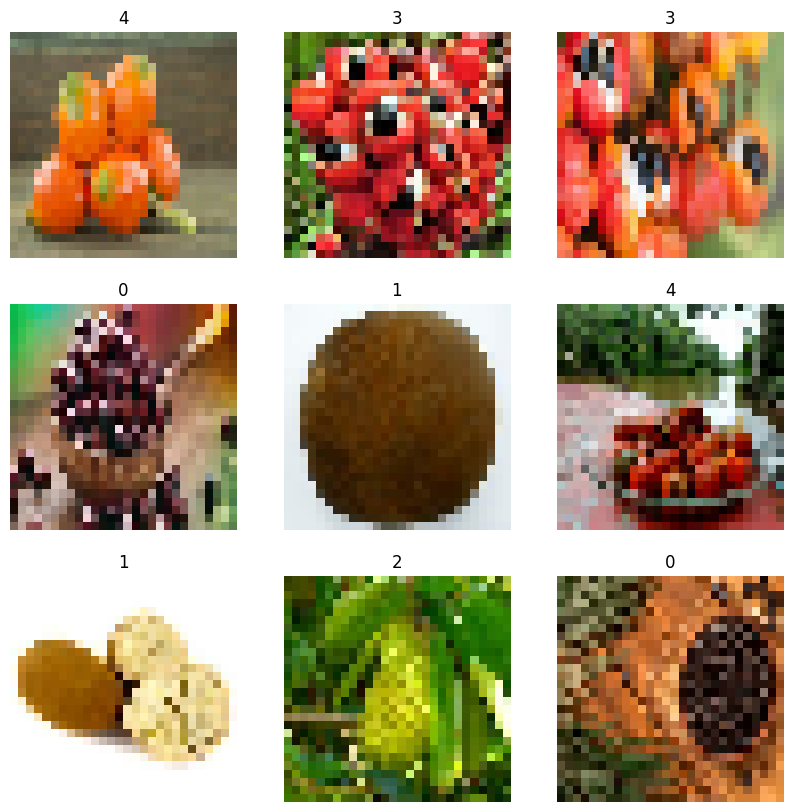

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [15]:
# This is a sample implementation, Thus I only use two augmentation, you can use more than two augmentation type for your project. Please check keras documentations for other available augmentation techniques.
from tensorflow.keras import layers
data_augmentation_layers = [
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
]
def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

In [16]:
model = keras.Sequential([
  layers.Input(shape=(128, 128, 3)),
  *data_augmentation_layers, # Include augmentation before the model layers
  layers.Conv2D(32, (3,3), activation="relu"),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(10, activation="softmax")
])

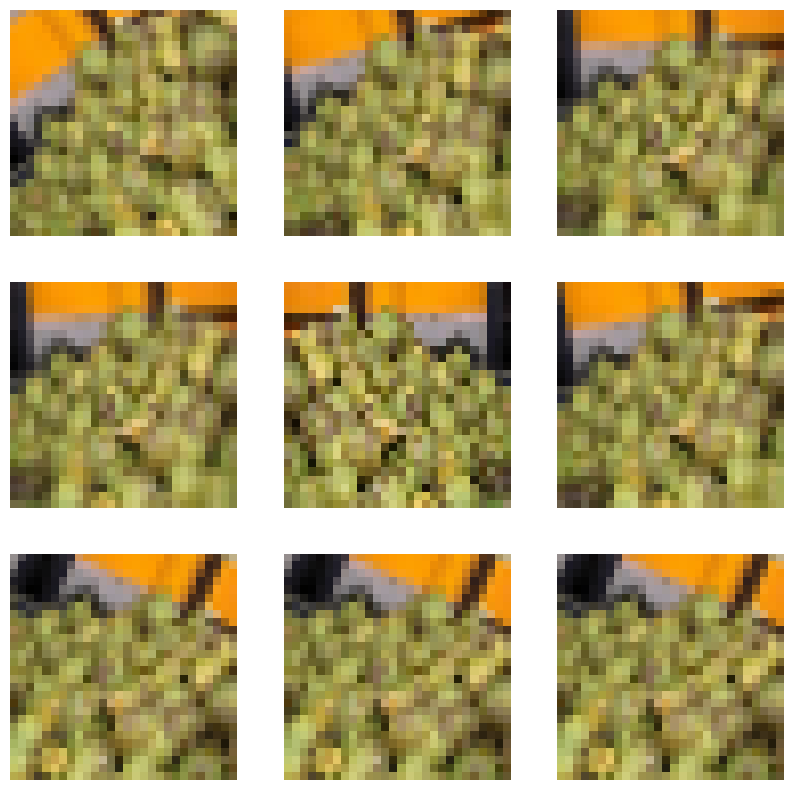

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(augmented_images[0]).astype("uint8"))
    plt.axis("off")

In [18]:
image_size = (28, 28)
input_shape = (image_size[0], image_size[1], 3)

inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize the images to values between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0
# Flatten the 28x28 images into 784-dimensional vectors
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)
# One-hot encode the labels (0-9) for classification
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

x_train = []
y_train = []
for images, labels in train_ds:
    x_train.extend(images.numpy())
    y_train.extend(labels.numpy())

x_test = []
y_test = []
for images, labels in val_ds:
    x_test.extend(images.numpy())
    y_test.extend(labels.numpy())

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)


x_train = x_train.reshape(-1, 28, 28, 3)
x_test = x_test.reshape(-1, 28, 28, 3)


# Define a simple CNN model
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")
])

# Compile the model
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
cnn_history = model.fit(x_train, y_train, epochs=10, validation_split=0.2)

# Train the model
model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Make predictions
predictions = model.predict(x_test[:5])
predicted_labels = np.argmax(predictions, axis=1)
print("Predicted labels:", predicted_labels)
print("Actual labels: ", y_test[:5])

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.0351 - loss: 89.1426 - val_accuracy: 0.1333 - val_loss: 49.8692
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.1690 - loss: 39.5404 - val_accuracy: 0.3333 - val_loss: 30.6848
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4174 - loss: 23.2064 - val_accuracy: 0.4000 - val_loss: 19.5213
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.3615 - loss: 17.2441 - val_accuracy: 0.4000 - val_loss: 16.3187
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4603 - loss: 10.6978 - val_accuracy: 0.4000 - val_loss: 11.2402
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7036 - loss: 4.1563 - val_accuracy: 0.4000 - val_loss: 8.0419
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6528 - loss: 4.0824 - val_accuracy: 0.4667 - val_loss: 6.0286
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6424 - loss: 2.7941 - val_accuracy: 0.6000 - val_loss: 2.3144
Epo

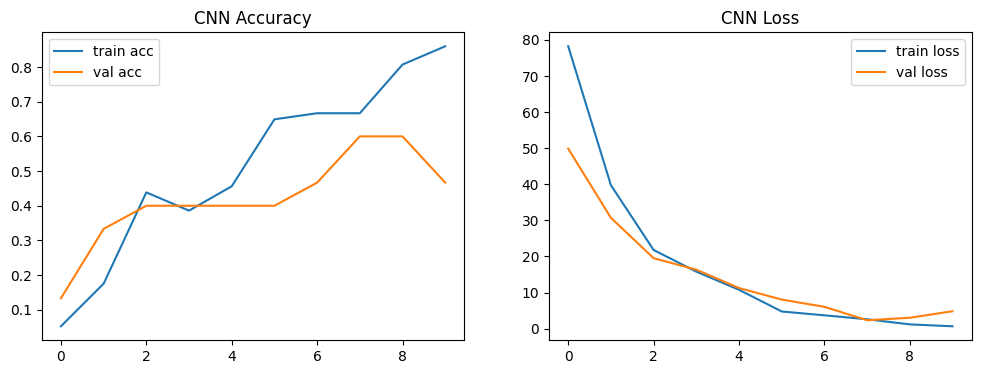

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step

Classification Report (CNN):
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.75      0.75      0.75         4
           2       0.00      0.00      0.00         1
           3       0.33      1.00      0.50         1
           4       0.33      0.25      0.29         4
           5       0.67      0.40      0.50         5

    accuracy                           0.56        18
   macro avg       0.47      0.57      0.48        18
weighted avg       0.57      0.56      0.54        18



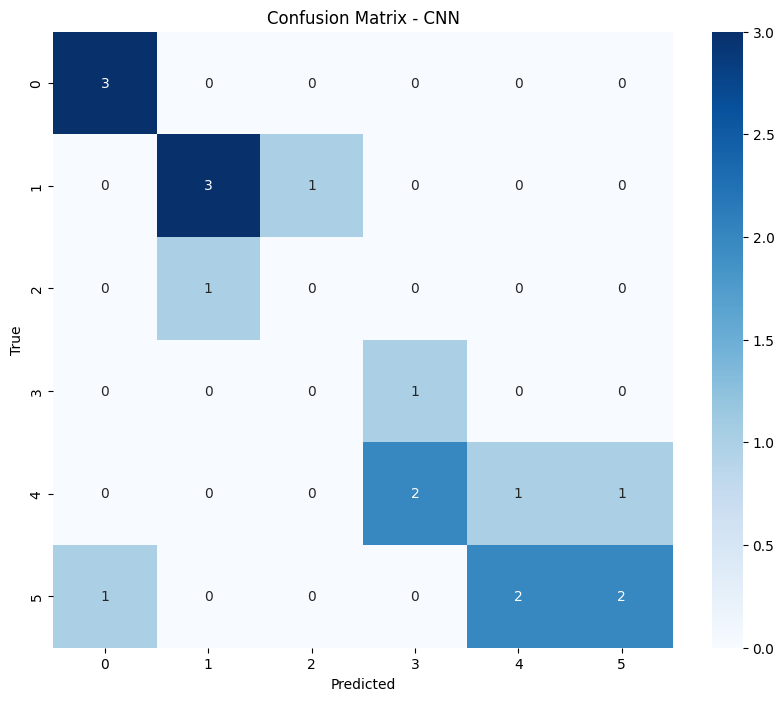

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='train acc')
plt.plot(cnn_history.history['val_accuracy'], label='val acc')
plt.title('CNN Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='train loss')
plt.plot(cnn_history.history['val_loss'], label='val loss')
plt.title('CNN Loss')
plt.legend()
plt.show()

y_pred = model.predict(x_test)
y_pred_classes_cnn = np.argmax(y_pred, axis=1)
y_true = y_test

print("\nClassification Report (CNN):")
print(classification_report(y_true, y_pred_classes_cnn))

cm = confusion_matrix(y_true, y_pred_classes_cnn)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [22]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False

transfer_model = models.Sequential([
    layers.Input(shape=(28, 28, 3)),
    layers.Resizing(32, 32),
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transfer_history = transfer_model.fit(x_train, y_train_cat, epochs=10, validation_split=0.2)
transfer_test_loss, transfer_test_acc = transfer_model.evaluate(x_test, y_test_cat)
print("Transfer Learning Test accuracy:", transfer_test_acc)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 12s/step - accuracy: 0.1457 - loss: 7.0401 - val_accuracy: 0.0667 - val_loss: 4.6888
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.2809 - loss: 4.1416 - val_accuracy: 0.2667 - val_loss: 3.5086
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2730 - loss: 3.6419 - val_accuracy: 0.4000 - val_loss: 2.5987
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4837 - loss: 2.4407 - val_accuracy: 0.5333 - val_loss: 1.9019
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6319 - loss: 1.3490 - val_accuracy: 0.6000 - val_loss: 1.6130
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7166 - loss: 0.9728 - val_accuracy: 0.6667 - val_loss: 1.4514
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6840 - loss: 0.6923 - val_accuracy: 0.7333 - val_loss: 1.3290
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8193 - lo

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

Classification Report (Transfer Learning):
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.33      0.50      0.40         4
           2       0.50      1.00      0.67         1
           3       0.50      1.00      0.67         1
           4       0.50      0.50      0.50         4
           5       0.50      0.20      0.29         5

    accuracy                           0.44        18
   macro avg       0.47      0.59      0.49        18
weighted avg       0.46      0.44      0.42        18



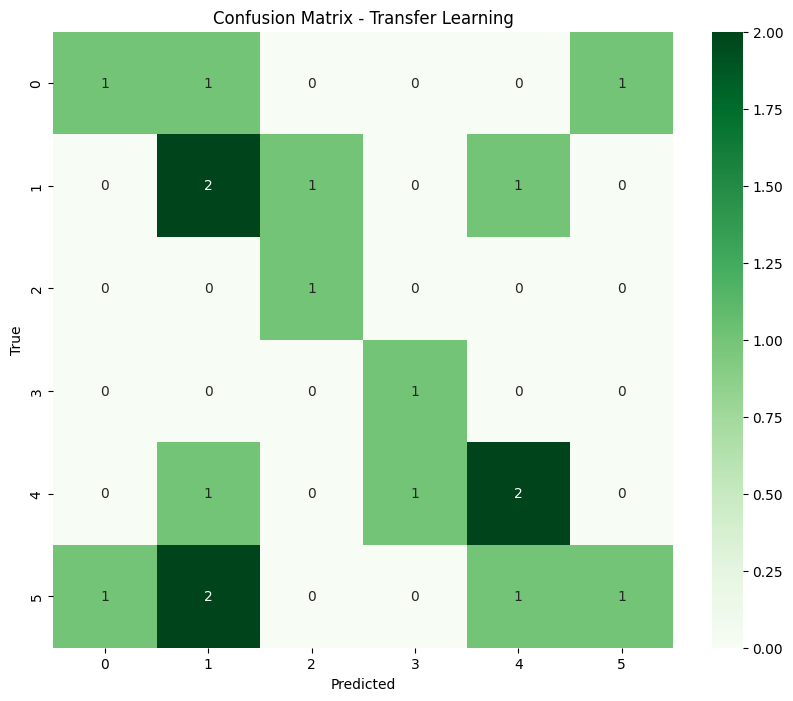

In [23]:
y_pred_transfer = transfer_model.predict(x_test)
y_pred_classes_transfer = np.argmax(y_pred_transfer, axis=1)

print("\nClassification Report (Transfer Learning):")
print(classification_report(y_true, y_pred_classes_transfer))

cm_transfer = confusion_matrix(y_true, y_pred_classes_transfer)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_transfer, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Transfer Learning')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [24]:
print(f"CNN Accuracy: {test_acc:.4f}")
print(f"Transfer Learning Accuracy: {transfer_test_acc:.4f}")

if transfer_test_acc > test_acc:
    print("Transfer learning performed better.")
elif transfer_test_acc < test_acc:
    print("Basic CNN performed better.")
else:
    print("Both models performed equally well.")

CNN Accuracy: 0.5556
Transfer Learning Accuracy: 0.4444
Basic CNN performed better.
